In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import distinctipy
from scipy.interpolate import UnivariateSpline
import glob,os
import matplotlib.colors as colors

import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt

COLOR = 'k'#'#FFFAF1'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 14 #12
plt.rcParams['ytick.major.size']  = 14#12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 8
plt.rcParams['ytick.minor.size']  = 8

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

peri=2458013

In [167]:
import numpy as np
import scipy
import quaternion as quat
import matplotlib.pyplot as plt
import pandas as pd

def evolving_axis_lightcurve(theta,phi,psi,a,b,c,alpha,beta,sun=[1,0,0]): 
    import warnings
    warnings.filterwarnings("ignore")
    
    if isinstance(theta, (np.floating, float)): theta=[theta]
    if isinstance(phi, (np.floating, float)): phi=[phi]
    if isinstance(psi, (np.floating, float)): psi=[psi]
    
    if len(beta.shape)==1:
        alpha=alpha[None,:]
        beta=beta[None,:]
    
    sun=quat.from_vector_part(sun)
    
    rot=np.array([np.cos(phi),np.sin(phi)*np.cos(psi),np.sin(phi)*np.sin(psi)]).T
    rot=np.einsum('ijk,ij->ijk',rot[:,None,:],beta)
    rot=quat.from_rotation_vector(rot)
    
    THETA,ALPHA=np.meshgrid(theta,alpha,indexing='ij')
    
    obs=np.array([np.cos(ALPHA),np.sin(ALPHA)*np.cos(THETA),np.sin(ALPHA)*np.sin(THETA)])
    obs=np.einsum('ijk->jki',obs)
    
    obs=quat.from_vector_part(obs)
    obs=quat.as_vector_part(rot*obs*rot.conj())
    
    sun=quat.as_vector_part(rot*sun*rot.conj())
    
    C=np.array([1/a**2,1/b**2,1/c**2])
    Ts=np.sqrt(np.einsum('ijk,ijk,k->ij',sun,sun,C))
    To=np.sqrt(np.einsum('ijk,ijk,k->ij',obs,obs,C))
    
    cosa=np.einsum('ijk,ijk,k->ij',sun,obs,C)/(Ts*To)
    cosa[np.where(cosa>1)]=1
    cosa[np.where(cosa<-1)]=-1
    
    aprime=np.arccos(cosa)
    
    aprime[np.isclose(aprime,0)]=0
    
    T=np.sqrt(np.abs(Ts**2+To**2+2*Ts*To*cosa))
    
    cosl=np.nan_to_num((Ts+To*cosa)/T,posinf=0,neginf=0)
    sinl=np.nan_to_num((To*np.sin(aprime))/T,posinf=0,neginf=0)

    lam=np.where(sinl>=0,np.arccos(cosl),-np.arccos(cosl)%(2*np.pi))
    lam[np.isclose(lam,0,atol=1e-6)]=0
    
    cotl=1/np.tan(lam/2)
    cotal=1/np.tan((aprime-lam)/2)
    
    L = np.where(np.sin(lam)!=0,sinl*np.sin(lam-aprime)*np.log(cotl*cotal),0)
    L += cosl+np.cos(lam-aprime)
    L[np.isclose(L,0)]=0
    L[L!=0] *= (np.pi*a*b*c*Ts*To/T)[L!=0]
    L[L==0] = 1e-15
    return(np.abs(L))

def magvalues(time,args,theta,phi,psi,betai,deltaV):
    p,a,b,c,alpha=args
    p=p/24
    beta=2*np.pi*((time)%p)/p
    curve=deltaV-2.5*np.log10(evolving_axis_lightcurve(theta,phi,psi,a,b,c,alpha,beta))
    return(curve[0,:])

In [160]:
datfile=pd.read_csv('..//Simulations//oumuamua_traj.csv')
times=datfile['Time'].to_numpy()
dist=datfile['Distance'].to_numpy()
tmax=np.max(times)/86400-peri

In [197]:
# Get phase angle data
phase=[]
starttimes=[]

dates=['2017-Jun-08','2017-Aug-09','2017-Sep-16','2017-Oct-24','2017-Dec-25']

for i in range(5):
    datfile=pd.read_csv('..//Lightcurves//Astrometrics//'+dates[i]+'_horizons_results.csv')
    times=datfile['Time'].to_numpy()/86400-peri
    data=datfile['Phase'].to_numpy()
    
    phase.append(UnivariateSpline(times,data))
    starttimes.append(times[0])
print(starttimes)

[-100.49305555550382, -38.493055555503815, -0.4930555555038154, 38.006944444496185, 99.50694444449618]


In [206]:
# Get sizes and periods from simulations

sizes=[35,55,75,95,115,150]
pinit=7.40

adict={}
bdict={}
cdict={}
perdict={}

tmaxdict={}

for i,s in enumerate(sizes):
    sadict={}
    sbdict={}
    scdict={}
    spdict={}
    stdict={}
    for file in glob.glob("../Simulations/logs/*pancake?_*a"+str(s)+"*.csv"):  
        mu=int(file.split("_")[-1][:-4])
        try: sadict[mu]
        except: 
            sadict[mu]=[]
            sbdict[mu]=[]
            scdict[mu]=[]
            spdict[mu]=[]
            stdict[mu]=[]
            
        pancake=pd.read_csv(file,names=['Times',"MoIs","a","b","c"]).drop(np.nan,axis=0)
        times=pancake['Times'].to_numpy(dtype=float)/86400-peri
        
        a=pancake['a'].to_numpy(dtype=float)/50
        b=pancake['b'].to_numpy(dtype=float)/50
        c=pancake['c'].to_numpy(dtype=float)/50
        
        axarray=np.sort(np.array([a,b,c]),axis=0)
        
        moi=pancake['MoIs'].to_numpy(dtype=float)
        
        per=pinit*moi/moi[0]
        
        sadict[mu].append(UnivariateSpline(times,axarray[2,:]))
        sbdict[mu].append(UnivariateSpline(times,axarray[1,:]))
        scdict[mu].append(UnivariateSpline(times,axarray[0,:]))
        spdict[mu].append(UnivariateSpline(times,per))
        
        stdict[mu].append(np.max(times))
        
    adict[s]=sadict
    bdict[s]=sbdict
    cdict[s]=scdict
    perdict[s]=spdict
    tmaxdict[s]=stdict

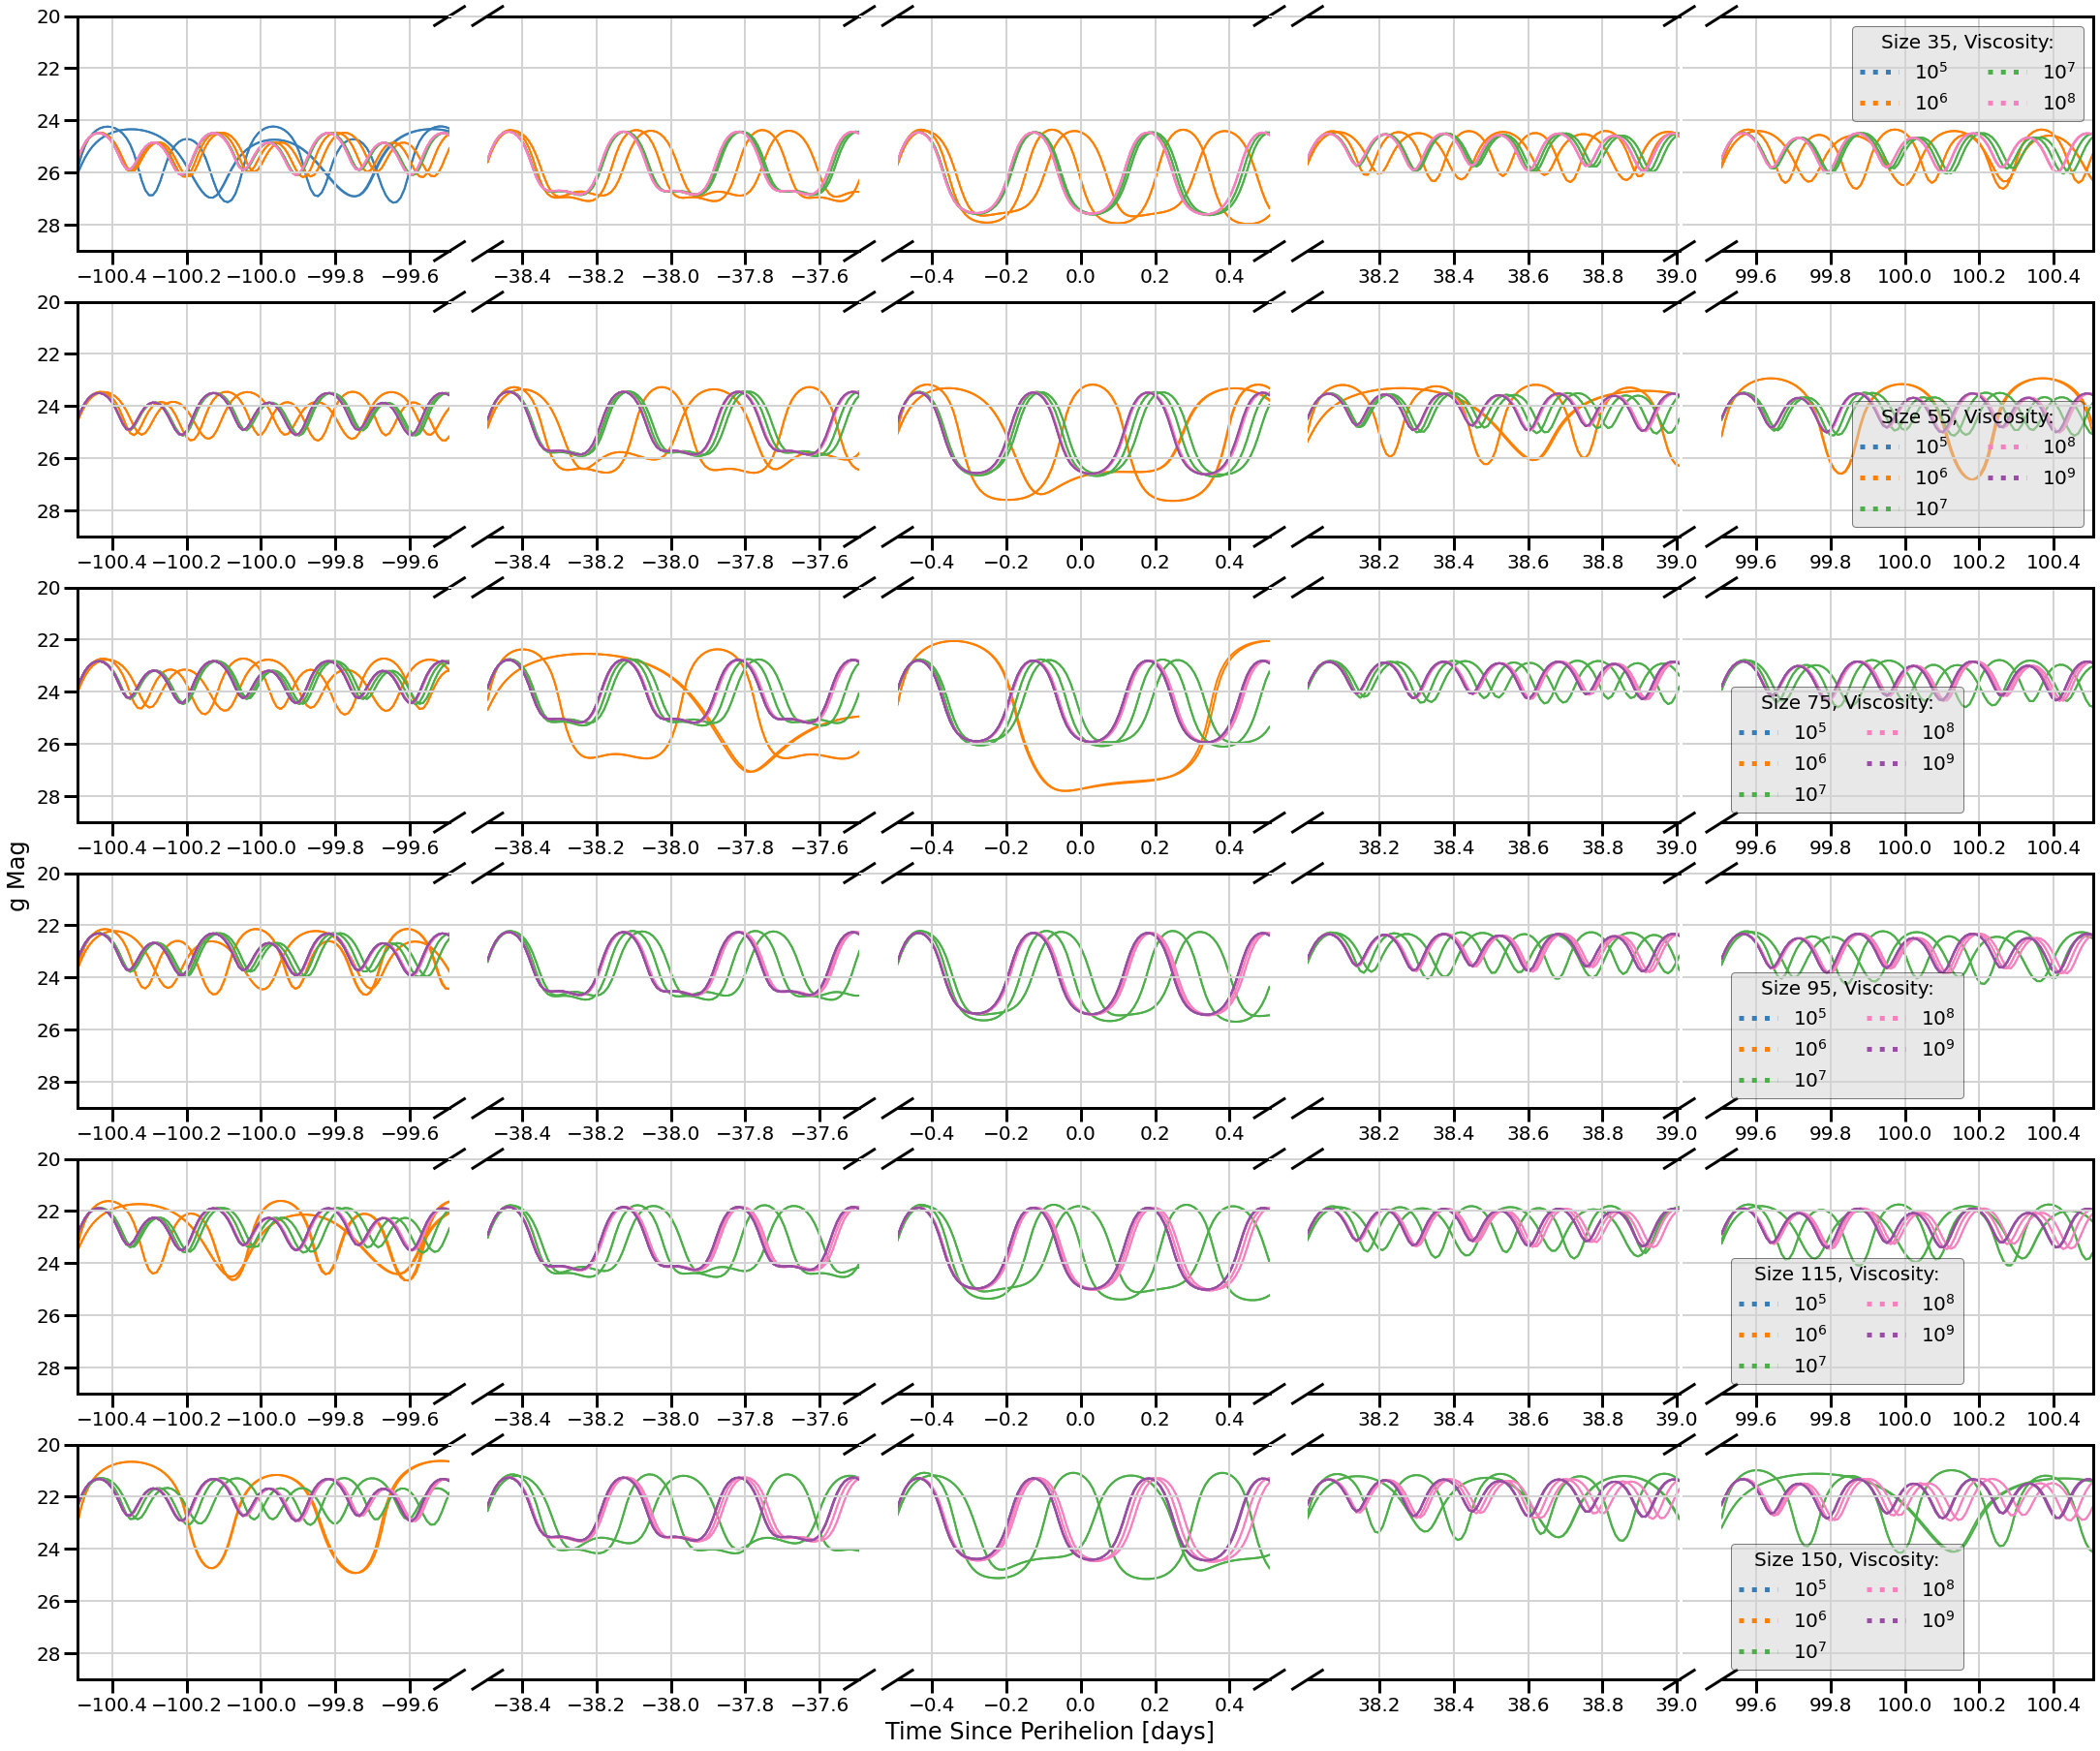

In [239]:
optparams=[4.75924567, 1.42272942, 1.24770105, 4.35406442, 32.18076141]
cols=['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#984ea3']

fig,axes=plt.subplots(ncols=5, nrows=6, figsize=(30,25), constrained_layout=True)
axes = axes.reshape(-1)
#plt.subplots_adjust(wspace=0.05)

d = .04
ymin=1000
ymax=0

for j in range(0,len(axes)):
    ## first subpanels
    if j%5 == 0:
        axes[j].spines['right'].set_visible(False)
        
        kwargs = dict(transform=axes[j].transAxes, color=COLOR, clip_on=False,lw=3,zorder=4)
        axes[j].plot((1-d,1+d), (-d,+d), **kwargs)
        axes[j].plot((1-d,1+d),(1-d,1+d), **kwargs)
        
    ## last subpanels per row
    elif j%5 == 4:
        axes[j].spines['left'].set_visible(False)
        axes[j].tick_params(axis='y', colors='lightgray',size=40, width=2)
        axes[j].set_yticklabels([])
        
        kwargs = dict(transform=axes[j].transAxes, color=COLOR, clip_on=False,lw=3,zorder=4)  # switch to the bottom axes
        axes[j].plot((-d,+d), (1-d,1+d), **kwargs)
        axes[j].plot((-d,+d), (-d,+d), **kwargs)
        
        
    ## middle subpanels
    else:    
        axes[j].spines['right'].set_visible(False)
        axes[j].spines['left'].set_visible(False)
        axes[j].tick_params(axis='y', colors='lightgray',size=40, width=2)
        axes[j].set_yticklabels([])
        
        kwargs = dict(transform=axes[j].transAxes, color=COLOR, clip_on=False,lw=3,zorder=4)
        axes[j].plot((1-d,1+d), (-d,+d), **kwargs)
        axes[j].plot((1-d,1+d),(1-d,1+d), **kwargs)
        kwargs.update(transform=axes[j].transAxes)  # switch to the bottom axes
        axes[j].plot((-d,+d), (1-d,1+d), **kwargs)
        axes[j].plot((-d,+d), (-d,+d), **kwargs)
        
    
    times=np.linspace(starttimes[j%5],starttimes[j%5]+1,100)
    s=sizes[j//5]
    
    handles=[]
    for mu in perdict[s].keys():
        handles.append(plt.Line2D([0,1],[0,1],linestyle='dotted',color=cols[mu-5],linewidth=5,label='$10^{%s}$'%mu))
        for k in range(len(perdict[s][mu])): 
            if np.max(times)<=tmaxdict[s][mu][k]:
                curve=[]
                for t in times:
                    curve.append(magvalues(np.array([t-np.min(times)]),
                                           (perdict[s][mu][k](t),adict[s][mu][k](t),bdict[s][mu][k](t),
                                            cdict[s][mu][k](t),phase[j%5](np.array([t]))),*optparams))
                axes[j].plot(times,curve,color=cols[mu-5],label=mu,linewidth=2,zorder=1)
                #axes[j].plot(times,curve,color=cols[mu-5],label=mu,linewidth=8,linestyle=(mu-5,(1,5)),zorder=2)
    axes[j].set_xlim([times[0],times[-1]])
    ymax=max(axes[j].get_ylim()[1],ymax)
    ymin=min(axes[j].get_ylim()[0],ymin)
    
    if j%5 == 4:
        axes[j].legend(handles=handles,ncol=2,title='Size '+str(s)+', Viscosity:',
              fancybox=True,edgecolor='black',facecolor='lightgray',framealpha=0.5)
    
    
for ax in axes:
    ax.grid(color='lightgray',lw=2,zorder=1)
    ax.set_ylim([np.ceil(ymax),np.floor(ymin)])
        
fig.supxlabel("Time Since Perihelion [days]")
fig.supylabel("g Mag")

plt.savefig('principal_axis_lightcurve_sims.pdf',
           bbox_inches='tight',dpi=300)